# Entity Linking with RAG
<br>
James Chapman<br>
CIS 830 Advanced Topics in AI – Term Project<br>
Kansas State University<br><br>

This notebook identifies EVERY DRUG MENTION (illicit/abusive) from list of 77 substances of interest.<br>

- Uses 'rag_prompt'
- Runs 4 LLMs (2 Paid Services & 2 Local HuggingFace Models)
    - o4-mini 
    - GPT-4o-mini
    - Meta-Llama-3.1-8B-Instruct
    - Qwen-4B

*** Saves response from every LLM call in separate text files.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import re
from tqdm import tqdm
tqdm.pandas()

from utils import (
    get_tweets_dataset, 
    extract_responses,
    extract_JSON_labels_and_explanations,
    extract_drug_labels,
    extract_RAG_drug_labels,
    extract_T_F_labels, 
    match_terms,
    get_confusion_matrix_and_metrics,
)
from llm_manager import (
    run_prompt_on_llm,
### paid #################
    # get_claude_response, 
    # get_openai_response, 
    # get_perplexity_response,
    get_openai_gpt4omini_response,
    get_openai_o4mini_response,
### local #################
    get_llama_response, 
    get_qwen_4b_response,                        
    #get_deepseek_qwen_response,
    # get_qwen_response,
    # get_mistral_response,
    cleanup_llama,
    cleanup_qwen,
    cleanup_qwen_4b,
    cleanup_deepseek_qwen,
    cleanup_mistral,
)

# imports used for RAG retrievers 
from __future__ import annotations
import logging
logging.disable(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

from langchain_core.documents import BaseDocumentCompressor, Document
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_core.retrievers import BaseRetriever
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document as LangchainDocument
from langchain.retrievers import BM25Retriever
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, SeleniumURLLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_cohere import CohereRerank
from langchain.globals import set_llm_cache
from langchain.cache    import SQLiteCache

# Always save responses from LLMs to a local SQLite database
set_llm_cache(SQLiteCache(database_path="data/llm_cache.sqlite"))

from dotenv import load_dotenv
load_dotenv()

# API keys
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["OPENAI_API_KEY"]    = os.getenv('First_Key')
os.environ["ANTHROPIC_API_KEY"] = os.getenv('anthropic-first-key')
os.environ["PPLX_API_KEY"]      = os.getenv('perplexity-api-key')
os.environ["COHERE_API_KEY"]    = os.getenv('cohere-first-key')

# models and embeddings
model_name       = "gpt-4.1-mini" # "gpt-4.1-mini"gpt-4o-mini o4-mini gpt-4.1-nano
model_provider   = "openai"
embeddings_model = "text-embedding-3-large"
llm        = init_chat_model(model_name, model_provider=model_provider)
embeddings = OpenAIEmbeddings(model=embeddings_model)

# constants
MAX_WORKERS      = 28
CONTEXT_WINDOW   = 1047576  # o4-mini tier 2

In [13]:
rag_prompt = """
### Role
You moderate social‑media content for drug‑related references.

### Tasks
Given a post **and a set of RAG context chunks**:
1. Detect every word or phrase (slang, euphemism, synonym, cultural references) that refers to an illicit drug or substance.
   • Include illegal, RX, OTC, or recreational drugs (using, buying, promoting, encouraging or glorifying drug use).
   • **Use the RAG chunks only as background knowledge for disambiguation; do NOT extract or return phrases that appear solely inside the chunks.**
2. Link each detected phrase to its matching **Index Term** (see list below). 
   • If the drug is *not* in the list, use "other".
3. Return **only** a valid JSON array, one object per match, using the schema  
   `{"index_term": "<Index Term or other>", "matched_phrase": "<exact text>"}`.

### Output: exact format
[
  {"index_term": "Codeine", "matched_phrase": "lean"},
  {"index_term": "Codeine", "matched_phrase": "codeine"},
  ...
]    

### Index Terms
2,6-Xylidine (2,6-Dimethylaniline, 2‑amino‑1,3‑dimethylbenzene) – A toxic aniline derivative used as an intermediate in manufacturing local anesthetics and dyes.
2‑Amino‑5‑chloropyridine (5‑Chloro‑2‑aminopyridine) – A breakdown product of the sleep drug zopiclone that serves as a urinary marker in drug tests.
2‑Fluoro‑2‑oxo PCE (CanKet, 2F‑NENDCK, 2‑FXE) – A novel ketamine‑like dissociative anesthetic sold illicitly for its hallucinogenic effects.
2‑Oxo‑3‑hydroxy‑LSD (2‑oxo‑3‑hydroxy lysergic acid diethylamide, oxo‑HO‑LSD) – The principal urinary metabolite of LSD produced after psychedelic use.
3‑Hydroxy flubromazepam () – A primary metabolite of the designer benzodiazepine flubromazepam detectable in urine for an extended period.
3‑Hydroxy flubromazepam glucuronide () – The glucuronidated form of 3‑hydroxy flubromazepam that aids bodily elimination of the parent drug.
4‑ANPP (Despropionyl fentanyl, 4‑anilino‑N‑phenethylpiperidine) – A key precursor and metabolite of fentanyl often found as an impurity in illicit opioid production.
4‑HIAA (4‑Hydroxyindole‑3‑acetic acid) – The main inactive metabolite excreted after psilocybin ingestion (“magic mushrooms”).
6‑Acetylmorphine (6‑Monoacetylmorphine, 6‑MAM) – An active intermediate metabolite formed almost immediately after heroin use.
7‑Aminoclonazepam () – The chief urinary metabolite of the prescription benzodiazepine clonazepam.
7‑Hydroxymitragynine (7‑OH‑Mitragynine) – A potent kratom alkaloid and human metabolite that produces strong opioid‑like effects.
7‑OH‑CBD glucuronide () – A conjugated metabolite formed during cannabidiol (CBD) metabolism and excreted in urine.
8‑Aminoclonazolam () – A metabolite indicating use of the designer benzodiazepine clonazolam in toxicology screens.
8R‑OH‑R‑HHC (8α‑hydroxy‑9β‑HHC) – A hydroxylated metabolite of the synthetic cannabinoid HHC produced during metabolism.
8S‑OH‑R‑HHC (8β‑hydroxy‑9β‑HHC) – The epimeric hydroxylated metabolite of R‑HHC likewise formed in users of HHC products.
α‑Hydroxyalprazolam (α‑OH‑alprazolam) – The major active metabolite of alprazolam (Xanax) contributing to its sedative effects.
α‑Hydroxybromazolam (α‑OH‑bromazolam) – An oxidative metabolite used to confirm bromazolam ingestion.
Amphetamine (Speed, Bennies, Adderall) – A central nervous system stimulant prescribed for ADHD that is frequently abused for euphoria and wakefulness.
Benzoylecgonine (BZE, Ecgonine benzoate) – The primary metabolite of cocaine measured in urine drug testing.
Bromazolam (XLI‑268, Fake Xanax) – A designer benzodiazepine sold illicitly that mimics the sedative effects of alprazolam.
Buprenorphine (Suboxone, Subutex, Bupe) – A partial opioid agonist used to treat opioid dependence and moderate pain with a ceiling on respiratory depression.
Carfentanil (Wildnil, Elephant tranquilizer) – An ultra‑potent fentanyl analog used for large‑animal sedation and deadly in microgram doses to humans.
CBD (Cannabidiol, Epidiolex) – A non‑intoxicating cannabinoid with antiepileptic and anxiolytic properties approved for certain seizure disorders.
Codeine (Lean, Purple Drank, Schoolboy) – A mild opioid painkiller and cough suppressant that is widely abused in syrup form for euphoric “lean.”
Cyclobenzaprine (Flexeril, Amrix, Fexmid) – A muscle relaxant related to tricyclic antidepressants used for short‑term relief of muscle spasms.
delta‑8‑THC‑COOH (11‑nor‑9‑carboxy‑delta‑8‑THC) – The main inactive urinary metabolite indicating use of delta‑8‑THC products.
delta‑9‑THC‑COOH (11‑nor‑9‑carboxy‑THC, THC‑COOH) – The principal inactive metabolite of cannabis’ delta‑9‑THC detected in urine screens.
Diphenhydramine (Benadryl, Nytol) – A first‑generation antihistamine with sedative and anticholinergic effects that is sometimes misused at high doses.
EDDP () – The inactive metabolite of methadone used to verify methadone compliance in treatment programs.
Fentanyl (China White, Apache, Duragesic) – A synthetic opioid 50–100 times stronger than morphine that drives many overdose deaths.
Flubromazepam () – A long‑acting “research chemical” benzodiazepine producing prolonged sedation and anxiolysis.
Gabapentin (Neurontin, Gralise, Gabbies) – An anticonvulsant prescribed for neuropathic pain and seizures that carries some abuse potential.
Hydrocodone (Vicodin, Norco, Vike) – A commonly prescribed semi‑synthetic opioid painkiller frequently diverted for nonmedical use.
Hydromorphone (Dilaudid, Dillies) – A potent morphine derivative used for severe pain with rapid onset and high addiction risk.
Ketamine (Special K, Keta, Ketalar) – A dissociative anesthetic causing trance‑like analgesia and hallucinations prized both medically and recreationally.
Lorazepam (Ativan) – A short‑acting benzodiazepine anxiolytic used for anxiety, insomnia, and seizure emergencies.
LSD (Acid, Lucy, Delysid) – A potent psychedelic that dramatically alters perception and cognition at microgram doses.
Marijuana (Cannabis, Weed, Pot) – The most widely used illicit drug, containing psychoactive cannabinoids THC only.
MDA (Sass, Love Drug, 3,4‑methylenedioxyamphetamine) – An entactogenic and psychedelic stimulant similar to MDMA but with stronger visuals.
MDMA (Ecstasy, Molly, 3,4‑methylenedioxymethamphetamine) – A popular club drug producing euphoria, empathy, and heightened sensory perception.
MDMB‑4en‑PINACA butanoic acid () – A primary metabolite confirming use of the potent synthetic cannabinoid MDMB‑4en‑PINACA.
Meperidine (Demerol, Pethidine) – A synthetic opioid analgesic now rarely used due to its toxic metabolite normeperidine.
Meprobamate (Miltown, Equanil) – A historical anxiolytic “tranquilizer” that produces barbiturate‑like sedation and dependency risk.
Methadone (Dolophine, Methadose, Done) – A long‑acting opioid agonist employed in maintenance therapy and chronic pain management.
Methamphetamine (Crystal Meth, Ice, Desoxyn) – A powerful stimulant drug with high addiction potential and neurotoxic effects when abused.
Metonitazene () – A nitazene‑class synthetic opioid comparable in potency to fentanyl and implicated in recent overdose clusters.
Mitragynine () – The main kratom alkaloid acting as a partial opioid receptor agonist with stimulant properties at low doses.
Morphine (MS Contin, Miss Emma, Morph) – The prototypical opioid analgesic used for severe pain but prone to tolerance and dependence.
N,N‑Dimethylpentylone () – A novel synthetic cathinone stimulant (“bath salt”) producing amphetamine‑like sympathomimetic effects.
Naltrexone (Vivitrol, Revia) – An opioid antagonist medication that blocks opioid and alcohol effects to support abstinence.
N‑Desethylmetonitazene () – A potent nitazene opioid analog/metabolite contributing to toxicity in illicit opioid samples.
Norbuprenorphine () – The primary active metabolite of buprenorphine with limited brain penetration and peripheral opioid effects.
Norcarfentanil () – The main metabolite of carfentanil detected in biological samples after exposure to the parent ultra‑potent opioid.
Nordiazepam (Desmethyldiazepam, Nordazepam) – A long‑acting active metabolite of diazepam that extends benzodiazepine sedation.
Norfentanyl () – The principal inactive metabolite of fentanyl used as a biomarker of fentanyl intake.
Norketamine () – The chief metabolite of ketamine that retains mild anesthetic and analgesic activity.
Normeperidine (Norpethidine) – A neurotoxic excitatory metabolite of meperidine that can cause seizures at high concentrations.
Noroxycodone () – An inactive N‑demethylated metabolite of oxycodone excreted renally.
N‑Pyrrolidinoetonitazene () – An emerging nitazene synthetic opioid of extreme potency implicated in fatal overdoses.
O‑Desmethyltramadol (O‑DSMT) – The active metabolite of tramadol with significantly stronger μ‑opioid receptor activity than the parent drug.
ortho‑Methylfentanyl (2‑Methylfentanyl) – A highly potent clandestine fentanyl analog historically known as “China White.”
Oxazepam (Serax) – A short‑to‑intermediate‑acting benzodiazepine used for anxiety and alcohol withdrawal.
Oxycodone (OxyContin, Percocet, Hillbilly Heroin) – A semi‑synthetic opioid widely prescribed for pain and heavily misused for its heroin‑like high.
Oxymorphone (Opana) – A very potent opioid analgesic withdrawn from U.S. markets due to abuse of its extended‑release form.
para‑Fluorofentanyl (p‑Fluorofentanyl) – A fentanyl analog with comparable potency that has surfaced in illicit opioid mixtures.
para‑Fluoronorfentanyl () – The N‑dealkylated metabolite of para‑fluorofentanyl used to confirm exposure to the parent analog.
Pentylone (bk‑MBDP, βk‑Methylbenzodioxylpentanamine) – A synthetic cathinone stimulant producing euphoria and increased energy similar to methylone.
Phencyclidine (PCP, Angel Dust, Sherm) – A dissociative anesthetic that causes hallucinations, detachment, and unpredictable behavior.
Pregabalin (Lyrica) – An anticonvulsant and anxiolytic agent used for neuropathic pain and prone to misuse for its calming effects.
Psilocin (4‑HO‑DMT) – The psychoactive metabolite of psilocybin responsible for the hallucinations of “magic mushrooms.”
Psilocybin (4‑PO‑DMT) – A natural prodrug compound in psychedelic mushrooms that converts to psilocin to produce its effects.
R‑HHC‑COOH () – The carboxylic acid metabolite of the R‑enantiomer of hexahydrocannabinol excreted after HHC use.
S‑HHC‑COOH () – The carboxylic acid metabolite of the S‑enantiomer of hexahydrocannabinol excreted after HHC use.
Speciociliatine () – A minor kratom alkaloid with weak opioid activity contributing modestly to the plant’s overall effects.
Temazepam (Restoril, Jellies) – A benzodiazepine hypnotic taken for short‑term insomnia and sometimes abused for its strong sedation.
Xylazine (Tranq, Rompun) – A veterinary sedative increasingly found as a street‑drug adulterant causing deep sedation and severe skin ulcers.
Zolpidem (Ambien, Stilnox) – A short‑acting non‑benzodiazepine hypnotic prescribed for insomnia that can cause complex sleep behaviors.
Zopiclone (Imovane) – A non‑benzodiazepine sleep aid used to treat insomnia, known for metallic after‑taste and next‑day drowsiness.

### BEGINNING of RAG Chunks  
{{rag_chunks}}
### ENDING of RAG Chunks

### Example #1 
Post: I got her hooked on that lean everyday she say she want codeine
[{"index_term": "Codeine", "matched_phrase": "lean"}, {"index_term": "Codeine", "matched_phrase": "codeine"}]

### Example #2 
Post: Pulled an all‑nighter on addy again.
[{"index_term": "Amphetamine", "matched_phrase": "addy"}]

### Example #3
Post: Popped two xans before class.
[{"index_term": "other", "matched_phrase": "xans"}]

### Example #4 (Cocaine not on the list)
Post: Picked up fresh snow to ride those white lines tonight ❄️
[{"index_term": "other", "matched_phrase": "snow"}, {"index_term": "other", "matched_phrase": "white lines"}]

Post: {{tweet_text}}
"""


# Load Chunks 
- created from '1 - rag_retriever.ipynb' 

In [3]:
DATA_CHUNKS_DIR = Path("data/chunks2")
chunks: list[Document] = []
with Path("data/chunks2.jsonl").open("r", encoding="utf-8-sig") as f:
    for line in f:
        obj = json.loads(line)
        chunks.append(
            Document(
                page_content=obj["content"],
                metadata=obj["metadata"],
            )
        )
print(f"Loaded {len(chunks):,} chunks ")

contextual_chunks = []
DATA_CHUNKS_DIR = Path("data/contextual_chunks2")
for fpath in sorted(
        DATA_CHUNKS_DIR.glob("*.jsonl"),
        key=lambda p: int(p.stem) if p.stem.isdigit() else p.stem
):
    with fpath.open(encoding="utf-8-sig") as f:
        for line in f:
            record = json.loads(line)
            contextual_chunks.append(
                Document(
                    page_content=record["content"],
                    metadata=record["metadata"],
                )
            )

print(f"Loaded {len(contextual_chunks):,} contextual chunks "
      f"from {len(list(DATA_CHUNKS_DIR.glob('*.jsonl')))} files.")


Loaded 9,695 chunks 
Loaded 9,695 contextual chunks from 439 files.


# Create Retrievers from chunks
- 6 retrievers (currently only using 1)

In [4]:

# We now have 2 kinds of chunks: 'vanilla' and 'contextualized'
# Create 3 types of retrievers: (for each type of chunking)
#       'embedding', 
#       'bm25',  
#       'combination' = embedding + bm25 + reranker

######  reranker  ##############################################################
reranker = CohereRerank(top_n=3, model="rerank-english-v3.0") #"rerank-english-v2.0")
################################################################################
#
def create_embedding_retriever(documents_):
    vector_store = FAISS.from_documents(documents_, embedding=embeddings)
    return vector_store.as_retriever(search_kwargs={"k": 4})

def batch_embed_texts(texts, embedding_model, chunk_size=100):
    all_embeddings = []
    for i in range(0, len(texts), chunk_size):
        batch = texts[i:i + chunk_size]
        all_embeddings.extend(embedding_model.embed_documents(batch))
    return all_embeddings

def batch_create_embedding_retriever(documents_):
    texts = [doc.page_content for doc in documents_]
    metadatas = [doc.metadata for doc in documents_]

    # Safe batching to avoid max token limits
    embeddings_list = batch_embed_texts(texts, embeddings, chunk_size=100)

    text_embedding_pairs = zip(texts, embeddings_list)

    return FAISS.from_embeddings(text_embeddings=text_embedding_pairs, embedding=embeddings, metadatas=metadatas).as_retriever(search_kwargs={"k": 4})


def create_bm25_retriever(documents_):
    retriever = BM25Retriever.from_documents(documents_, language="english")
    return retriever

# Function to create a combined retriever: embedding + BM25 + reranker
class EmbeddingBM25RerankerRetriever:
    def __init__(
        self,
        vector_retriever: BaseRetriever,
        bm25_retriever: BaseRetriever,
        reranker: BaseDocumentCompressor,
    ):
        self.vector_retriever = vector_retriever
        self.bm25_retriever = bm25_retriever
        self.reranker = reranker

    def invoke(self, query: str):
        vector_docs = self.vector_retriever.invoke(query)
        bm25_docs = self.bm25_retriever.invoke(query)

        combined_docs = vector_docs + [
            doc for doc in bm25_docs if doc not in vector_docs
        ]

        reranked_docs = self.reranker.compress_documents(combined_docs, query)
        return reranked_docs
    
##################################################################################
# vanilla chunks
##################################################################################

embedding_retriever = create_embedding_retriever(chunks)

bm25_retriever = create_bm25_retriever(chunks)

embedding_bm25_retriever_rerank = EmbeddingBM25RerankerRetriever(
    vector_retriever=embedding_retriever,
    bm25_retriever=bm25_retriever,
    reranker=reranker,
)

##################################################################################
# contextualized chunks
##################################################################################

contextual_embedding_retriever = batch_create_embedding_retriever(contextual_chunks)

contextual_bm25_retriever = create_bm25_retriever(contextual_chunks)

contextual_embedding_bm25_retriever_rerank = EmbeddingBM25RerankerRetriever(
    vector_retriever=contextual_embedding_retriever,
    bm25_retriever=contextual_bm25_retriever,
    reranker=reranker,
)

In [5]:
tweets = get_tweets_dataset()
SEED = 777
tweets = ( tweets.sample(n=1_000, random_state=SEED, replace=False)
                 .sort_index()
                 .reset_index(drop=True)
)
tweets.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       1000 non-null   object
 1   label                      1000 non-null   object
 2   tweet_num                  1000 non-null   int64 
 3   found_terms                1000 non-null   object
 4   found_index_terms          1000 non-null   object
 5   GPT_found_terms            1000 non-null   object
 6   GPT_found_index_terms      1000 non-null   object
 7   pubchem_found_terms        1000 non-null   object
 8   pubchem_found_index_terms  1000 non-null   object
 9   redmed_found_terms         1000 non-null   object
 10  redmed_found_index_terms   1000 non-null   object
 11  DEA_found_terms            1000 non-null   object
 12  DEA_found_index_terms      1000 non-null   object
dtypes: int64(1), object(12)
memory usage: 101.7+ KB


# Run retriever on tweets
- For every tweet, gather 3 most relevant chunks (each chunk will have relevance score)

In [ ]:
def run_retriever_on_tweets(retriever, directory, tweets):
    os.makedirs(f"data/{directory}", exist_ok=True)
    all_retrieved_chunks = []
    for i, row in tqdm(tweets.iterrows(), total=tweets.shape[0]):                          
        text = row["text"]
        retrieved_chunks = retriever.invoke(text)
        all_retrieved_chunks.extend(retrieved_chunks)
        with open(f"data/{directory}/{i}.txt", "w", encoding="utf-8-sig") as f:
            for chunk in retrieved_chunks:
                json.dump(
                    {
                        "metadata": chunk.metadata,
                        "content":  chunk.page_content,
                    },
                    f,
                    ensure_ascii=False,
                    default=str,
                )
                f.write("\n")
    return 
# run once
run_retriever_on_tweets(contextual_embedding_bm25_retriever_rerank, 'retrieved_chunks__contextual_rerank', tweets)

In [8]:
def load_retrieved_chunks(directory):
    all_retrieved_chunks: List[Document] = []
    for i in range(tweets.shape[0]):       
        retrieved_chunks: List[Document] = []
        with open(f"data/{directory}/{i}.txt", "r", encoding="utf-8-sig") as f:
            for line in f:
                obj = json.loads(line)
                retrieved_chunks.append(
                    Document(
                        page_content=obj["content"],
                        metadata=obj["metadata"],
                    )
                )
        all_retrieved_chunks.append(retrieved_chunks)
    return all_retrieved_chunks
all_retrieved_chunks = load_retrieved_chunks("retrieved_chunks__contextual_rerank")

all_relevance_scores = []
for ret_chunks in all_retrieved_chunks:
    one_tweet_relevance_scores = []
    for c in ret_chunks:
        one_tweet_relevance_scores.append(c.metadata['relevance_score'])
    all_relevance_scores.append(one_tweet_relevance_scores)
    
print(len(all_retrieved_chunks))

1000


# Analyze Retrieved Chunks
- Inspect relevance scores
- Inspect relevance score distributions & for each tweet
- Determine relevance score threshold (used to determine if the chunks will be used in the prompt)

In [ ]:
# all_retrieved_chunks : List[List[Document]]
# one inner list per tweet, 3 chunks per list
all_relevance_scores = []          # shape → 1000 × 3
flat_scores          = []          # shape → 3000

for tweet_chunks in all_retrieved_chunks:
    scores = [c.metadata.get("relevance_score", 0.0)
              for c in tweet_chunks]
    all_relevance_scores.append(scores)
    flat_scores.extend(scores)

scores = np.array(flat_scores)
tweet_df = pd.DataFrame(all_relevance_scores,
                        columns=[f"chunk_{i}" for i in range(1, 4)])
tweet_df["tweet_max"]   = tweet_df.max(axis=1)
tweet_df["tweet_mean"]  = tweet_df.mean(axis=1)
tweet_df["tweet_stdev"] = tweet_df.std(axis=1)

summary = pd.Series(scores).describe(percentiles=[.01,.05,.10,.25,.5,.75,.90,.95,.99])
display(summary.to_frame("Relevance Score"))

,Relevance Score
count,3.000000e+03
mean,2.333519e-02
std,1.265687e-01
min,3.028843e-08
1%,3.950356e-08
5%,6.412061e-08
10%,1.226339e-07
25%,6.179393e-07
50%,9.295810e-06
75%,1.944937e-04


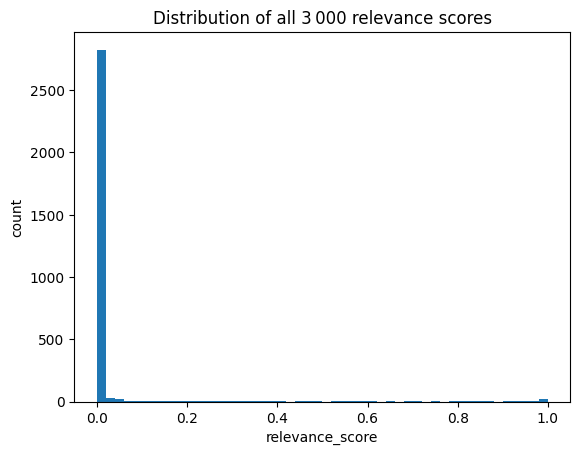

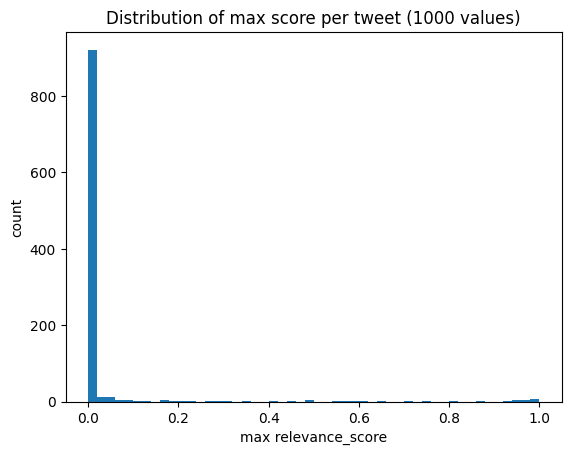

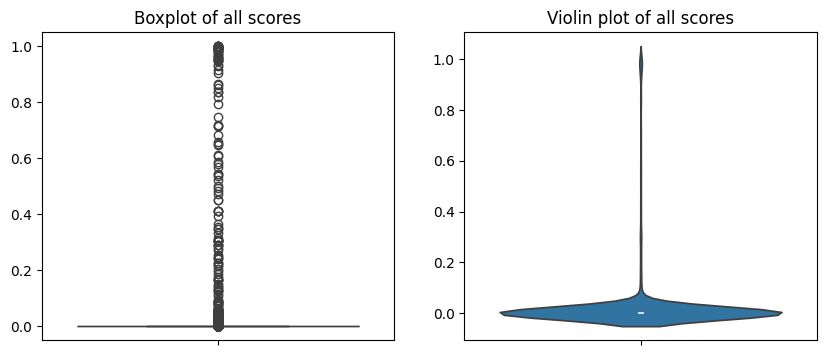

In [10]:

plt.figure()
plt.hist(scores, bins=50)
plt.title("Distribution of all 3 000 relevance scores")
plt.xlabel("relevance_score")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(tweet_df["tweet_max"], bins=50)
plt.title("Distribution of max score per tweet (1000 values)")
plt.xlabel("max relevance_score")
plt.ylabel("count")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(y=scores, ax=ax[0]);           ax[0].set_title("Boxplot of all scores")
sns.violinplot(y=scores, ax=ax[1]);        ax[1].set_title("Violin plot of all scores")
plt.show()


In [11]:
threshold = 0.05

n_chunks_below = int((scores < threshold).sum())
print(f"Chunks with relevance_score < {threshold} : {n_chunks_below:,} / {scores.size}")

n_tweets_all_below = int((tweet_df.max(axis=1) < threshold).sum())
print(f"Tweets where max(chunk) < {threshold}     : {n_tweets_all_below:,} / {len(tweet_df)}")



threshold = 0.2

n_chunks_below = int((scores < threshold).sum())
print(f"Chunks with relevance_score < {threshold} : {n_chunks_below:,} / {scores.size}")

n_tweets_all_below = int((tweet_df.max(axis=1) < threshold).sum())
print(f"Tweets where max(chunk) < {threshold}     : {n_tweets_all_below:,} / {len(tweet_df)}")


threshold = 0.5

n_chunks_below = int((scores < threshold).sum())
print(f"Chunks with relevance_score < {threshold} : {n_chunks_below:,} / {scores.size}")

n_tweets_all_below = int((tweet_df.max(axis=1) < threshold).sum())
print(f"Tweets where max(chunk) < {threshold}     : {n_tweets_all_below:,} / {len(tweet_df)}")


Chunks with relevance_score < 0.05 : 2,862 / 3000
Tweets where max(chunk) < 0.05     : 939 / 1000
Chunks with relevance_score < 0.2 : 2,904 / 3000
Tweets where max(chunk) < 0.2     : 960 / 1000
Chunks with relevance_score < 0.5 : 2,941 / 3000
Tweets where max(chunk) < 0.5     : 974 / 1000


In [12]:
################################################################################
# Print every chunk whose relevance_score [0.02, 0.05]
##############################################################################
LOW, HIGH = 0.02, 0.05
preview_chars = 30000

count = 0
for tweet_idx, tweet_chunks in enumerate(all_retrieved_chunks):
    for chunk_idx, doc in enumerate(tweet_chunks):
        score = doc.metadata.get("relevance_score", 0.0)
        if LOW <= score <= HIGH:
            count += 1
            print(f"Tweet {tweet_idx:4d}  |  Chunk {chunk_idx}  |  score={score:.4f}")
            print("-" * 80)
            print(doc.page_content[:preview_chars].replace("\n", " ") + " …")
            print()

print(f"\nTotal chunks in [{LOW}, {HIGH}]: {count:,}")


Tweet   65  |  Chunk 0  |  score=0.0455
--------------------------------------------------------------------------------
Drug: Codeine | cid: 5284371 Source: psychonaut | Source description: Codeine (also known as 3-Methylmorphine) is a naturally-occurring opioid substance of the morphinan class found in extracts of the poppy, particularly Papaver bracteatum.[3] Members of this group produce effects such as sedation, cough suppression, and euphoria when administered.                      Text:                      Erowid Experience Vaults: Codeine  Common forms  Codeine is available within pharmacies across the world in a variety of forms that combine it with other products that are dangerous or even fatal to consume at higher dosages. This is done to act as a deterrent to prevent their recreational use but can easily be circumvented with the use of a cold water extraction.    Co-codamol contain 500mg of paracetamol per 8mg of codeine. It is available behind the counter in any British 

# RUN 4 MODELS: rag_prompt

In [ ]:

# I settled with a threshold of 0.2
THRESHOLD = 0.2

def run_RAG_prompt_on_llm(get_funct, directory, prompt, tweets):
    os.makedirs(f"data/{directory}", exist_ok=True)
    responses = []
    for i, row in tqdm(tweets.iterrows()):                          
        text = row["text"]
        ######################################################################
        # get the relevant chunks for this tweet
        ########################################################################
        retrieved_chunks = all_retrieved_chunks[i]
        rag_chunks = ''
        for chunk_idx, chunk in enumerate(retrieved_chunks):
            score = chunk.metadata.get("relevance_score")
            if score >= THRESHOLD:
                rag_chunks += chunk.page_content
        #######################################################################
        if rag_chunks != '': 
            i_prompt = (
                prompt
                .replace("{{rag_chunks}}", rag_chunks)
                .replace("{{tweet_text}}", text)
            )
            response = get_funct(i_prompt)
            # save each to file in data/directory
            with open(f"data/{directory}/{i}.json", "w") as f:
                f.write(response)
            responses.append(response)
    return responses

In [15]:
# o4-mini (smarter than GPT-4o-mini)
responses = run_RAG_prompt_on_llm(get_openai_o4mini_response, "o4mini_rag", rag_prompt, tweets)

# GPT-4o-mini
responses = run_RAG_prompt_on_llm(get_openai_gpt4omini_response, "gpt4omini_rag", rag_prompt, tweets)

# Meta-Llama-3.1-8B-Instruct
responses = run_RAG_prompt_on_llm(get_llama_response, "llama_rag", rag_prompt, tweets)
cleanup_llama()

# Qwen-4B
responses = run_RAG_prompt_on_llm(get_qwen_4b_response, "qwen_4b_rag", rag_prompt, tweets)
cleanup_qwen_4b()

0it [00:00, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

1000it [22:11,  1.33s/it]
0it [00:00, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

1000it [41:48,  2.51s/it]


In [19]:
THRESHOLD = 0.2
def get_RAG_idxs(tweets):
    RAG_idxs = []
    for i, row in tqdm(tweets.iterrows()):                          
        text = row["text"]
        ######################################################################
        # get the relevant chunks for this tweet
        ########################################################################
        retrieved_chunks = all_retrieved_chunks[i]
        rag_chunks = ''
        for chunk_idx, chunk in enumerate(retrieved_chunks):
            score = chunk.metadata.get("relevance_score")
            if score >= THRESHOLD:
                rag_chunks += chunk.page_content
        #######################################################################
        if rag_chunks != '': 
            RAG_idxs.append(i)
    print(len(RAG_idxs))
    return RAG_idxs

RAG_idxs = get_RAG_idxs(tweets)
RAG_only_tweets = tweets.iloc[RAG_idxs].copy()
print(len(RAG_only_tweets))

1000it [00:00, 66014.61it/s]

40
40


In [ ]:
:)